In [1]:
import copy
import datetime
import warnings
warnings.filterwarnings(action='ignore') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 시각화
import seaborn as sns
# 결측치
import missingno as msno

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection, linear_model
from sklearn.metrics import auc

# 파이프라인
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn import cluster


In [2]:
x_train = pd.read_excel('x_train.xlsx')
x_test = pd.read_excel('x_test.xlsx')
y_train = pd.read_excel('y_train.xlsx')
y_test = pd.read_excel('y_test.xlsx')

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
smote = SMOTE(random_state=42)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n', y_train_over.value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (13674, 100) (13674, 1)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (24808, 100) (24808, 1)
SMOTE 적용 후 값의 분포 :
 재구매여부
0        12404
1        12404
dtype: int64


## 기본 모델 학습

In [5]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score

In [6]:
x_train_resample, x_test, y_train_resample, y_test =\
model_selection.train_test_split(x_train_over, y_train_over, test_size=0.3, random_state=0)

In [7]:
clf_DTC_re = sklearn.tree.DecisionTreeClassifier(random_state=0)
clf_DTC_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_DTC_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9532


In [8]:
clf_Bagging_re = ensemble.BaggingClassifier()
clf_Bagging_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_Bagging_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9618


In [9]:
clf_RFC_re = ensemble.RandomForestClassifier()
clf_RFC_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_RFC_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9635


## 부스팅 알고리즘 학습

In [10]:
from xgboost import XGBClassifier

In [11]:
clf_XGB_re = XGBClassifier(random_state=0)
clf_XGB_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9637


In [12]:
clf_GB_re = ensemble.GradientBoostingClassifier()
clf_GB_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_GB_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9452


## 하이퍼파라미터 튜닝

In [13]:
from sklearn.model_selection import GridSearchCV

### XGboost

In [14]:
clf_XGB_re = XGBClassifier(random_state=0, colsample_bytree=0.75, learning_rate=0.02, max_depth=7, n_estimators=1000, reg_alpha=0.03)
clf_XGB_re.fit(x_train_resample, y_train_resample)
acc = accuracy_score(y_test, clf_XGB_re.predict(x_test))
print("The accuracy score on test set: {:.4f}".format(acc))

The accuracy score on test set: 0.9629


## 리포트

In [15]:
from sklearn.metrics import classification_report

predictions = clf_XGB_re.predict(x_test)
print(classification_report(y_test, predictions)) # Precision, Recall, F1-score 등을 확인할 수 있습니다.

print("Accuracy on Training set: {:.3f}".format(clf_XGB_re.score(x_train, y_train)))
print("Accuracy on Test set: {:.3f}".format(clf_XGB_re.score(x_test, y_test)))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3732
           1       0.95      0.98      0.96      3711

    accuracy                           0.96      7443
   macro avg       0.96      0.96      0.96      7443
weighted avg       0.96      0.96      0.96      7443

Accuracy on Training set: 0.964
Accuracy on Test set: 0.963


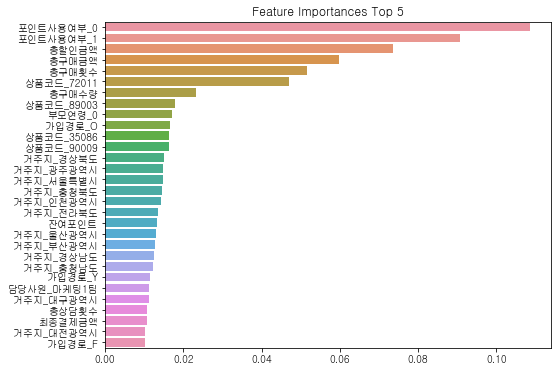

In [17]:
import seaborn as sns

feature_importance_values = clf_XGB_re.feature_importances_
# Top 중요도로 정렬하고, 쉽게 시각화하기 위해 Series 변환
feature_importances = pd.Series(feature_importance_values, index=x_train.columns)
# 중요도값 순으로 Series를 정렬
feature_top5 = feature_importances.sort_values(ascending=False)[:30]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

## ROC 커브로 비교

In [ ]:
from sklearn.metrics import roc_curve, auc

models=['Bagging', 'RFC', 'DTC', 'XGB', 'GB']


plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


for i in models:

    globals()['clf_{}_re_pred'.format(i)] = \
    globals()['clf_{}_re'.format(i)].predict_proba(x_test)
    
    globals()['clf_{}_re_roc'.format(i)]=\
    globals()['clf_{}_re_pred'.format(i)][:,1]
   
    globals()['fpr_{}_re'.format(i)],\
    globals()['tpr_{}_re'.format(i)], \
    globals()['_{}'.format(i)] \
    =roc_curve(y_true=y_test, y_score=globals()['clf_{}_re_roc'.format(i)]) 
    
    globals()['roc_auc_{}_re'.format(i)] = \
    auc(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)])

    
    plt.plot(globals()['fpr_{}_re'.format(i)], globals()['tpr_{}_re'.format(i)]
             , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}_re'.format(i)])

plt.legend()
plt.show()

#### 앙상블과 단일알고리즘 비교

In [ ]:
# # 데이터셋을 불러오고,학습용 데이터와 테스트용 데이터로 분리하여 반환하는 함수입니다.

# def load_data():
#   x_train_resample, x_test, y_train_resample, y_test = model_selection.train_test_split(x_train_over, y_train_over, test_size=0.3, random_state=0)
#   return x_train_resample, x_test, y_train_resample, y_test

# """
# 1. 동일한 모델을 사용하는 BaggingClassifier를 정의하여
#    학습시키고, 예측을 수행한 결과를 반환하는 함수를 구현합니다.
   
#    Step01. Bagging에 사용할 분류 모델을 설정하여 
#            BaggingClassifier를 정의합니다.
           
#            모델은 의사결정 나무(DecisionTreeClassifier)를
#            사용합니다.
           
#            n_estimators는 자유롭게 설정합니다.
   
#    Step02. BaggingClassifier를
#            학습용 데이터에 맞춰 학습을 시킵니다.
   
#    Step03. 테스트 데이터에 대한 예측을 수행합니다.
# """
# def Bagging_Clf(x_train_resample, x_test, y_train_resample, y_test):
    
#     ba_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators = 100)
    
#     ba_clf.fit(x_train_resample, y_train_resample)
    
#     pred = ba_clf.predict(x_test)
    
#     return ba_clf, pred
    
# # 데이터를 불러오고, 모델 학습 및 예측을 진행하기 위한 함수입니다.
# def main():
    
#     x_train_resample, x_test, y_train_resample, y_test = load_data()
    
#     ba_clf, pred = Bagging_Clf(x_train_resample, x_test, y_train_resample, y_test)
    
#     print('Bagging Classifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))
    
#     # 단일 의사결정 나무를 학습했을 때 결과 예측하기
#     single_dt = DecisionTreeClassifier()
#     single_dt.fit(x_train_resample,y_train_resample)
#     single_pred = single_dt.predict(x_test)
#     print('Single Decision Tree Classifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, single_pred)))

# if __name__ =="__main__":
#     main()